## Part IV.1: Experiments with CNN Model Architecture

In this section, experiments and tuning exercises will be conducted using CNN foundational model architecture.  This will include the following:

1.  Experiments with different CNN model architectures (number of conv layers, etc.)
2.  Experiments with regularization methods (if necessary) including dropout layers, batch normalization, etc.
3.  Hyperparameter tuning/optimization

In [62]:
import time
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from sklearn.utils import class_weight
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, ConfusionMatrixDisplay, confusion_matrix

### Load Prepared Datasets

In [2]:
LOAD_FROM_GDRIVE = True

In [3]:
if(LOAD_FROM_GDRIVE):
    # mount google drive to load data
    from google.colab import drive
    drive.mount('/content/drive')

    dataset_root = '/content/drive/MyDrive/Datasets/sepsis/prepared'

    X_train = np.load(os.path.join(dataset_root, 'X_train.npy'))
    y_train = np.load(os.path.join(dataset_root, 'y_train.npy'))

    X_test = np.load(os.path.join(dataset_root, 'X_test.npy'))
    y_test = np.load(os.path.join(dataset_root, 'y_test.npy'))

    X_val =  np.load(os.path.join(dataset_root, 'X_val.npy'))
    y_val = np.load(os.path.join(dataset_root, 'y_val.npy'))

else:
    # load from datalake (S3)
    !aws s3 cp $s3_datalake_path_prepared $local_data_path_csv --recursive --exclude "*" --include "*.npy"

    X_train = np.load(os.path.join(local_data_path_csv, 'X_train.npy'))
    y_train = np.load(os.path.join(local_data_path_csv, 'y_train.npy'))

    X_test = np.load(os.path.join(local_data_path_csv, 'X_test.npy'))
    y_test = np.load(os.path.join(local_data_path_csv, 'y_test.npy'))

    X_val =  np.load(os.path.join(local_data_path_csv, 'X_val.npy'))
    y_val = np.load(os.path.join(local_data_path_csv, 'y_val.npy'))

Mounted at /content/drive


In [4]:
# inspect the loaded data
print(f"Train data shape: X: {X_train.shape}, y: {y_train.shape}")
print(f"Test data shape: X: {X_test.shape}, y: {y_test.shape}")
print(f"Validation data shape: X: {X_val.shape}, y: {y_val.shape}")

Train data shape: X: (19524, 24, 32), y: (19524,)
Test data shape: X: (2440, 24, 32), y: (2440,)
Validation data shape: X: (2441, 24, 32), y: (2441,)


In [5]:
# refactor targets to work for modeling
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_val = y_val.reshape(-1,1)

In [124]:
# global default training parameters
NUM_EPOCHS = 30
BATCH_SIZE = 32
LEARNING_RATE = 0.001

# calculate class weights to handle class imbalance
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train.reshape(-1,))
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.535226711990789, 1: 7.596887159533074}

In [13]:
y_train.sum() / len(y_train)

0.06581643105920917

In [14]:
y_val.sum() / len(y_val)

0.0680049160180254

In [47]:
y_val.sum()

166

### Helper Functions for Training

In [125]:
# compile and train model
def compile_and_train_adam(model, checkpoint_callback):
  # Compile the model
  model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()]
  )
  # Train the model
  history = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, class_weight=class_weights, callbacks=[checkpoint_callback])
  return history

# plot loss curves
def plot_loss(history, title):
  plt.plot(history_cnn_baseline.history['loss'])
  plt.plot(history_cnn_baseline.history['val_loss'])
  plt.title(title)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['Tain', 'Val'])
  plt.show()

# run forward pass and plot confusion matrix
def predict_and_plot_confusion(model, title):
  y_pred = model.predict(X_val)
  cm = confusion_matrix(y_val, np.round(y_pred).tolist())
  ConfusionMatrixDisplay(confusion_matrix=cm).plot();
  plt.title(title)

### Baseline CNN Model

In [ ]:
# setup checkpoint
checkpoint_filepath = '/content/drive/MyDrive/Datasets/sepsis/models/cnn-1.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_binary_accuracy',
    mode='max',
    save_best_only=True)

cnn_baseline = tf.keras.Sequential([

  tf.keras.layers.Input(shape=X_train.shape[1:]),

  tf.keras.layers.Conv1D(256, kernel_size=3, activation='relu'),
  tf.keras.layers.MaxPooling1D(2),

  tf.keras.layers.Flatten(),

  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
# Train the model
history_cnn_baseline = compile_and_train_adam(cnn_baseline)

Epoch 1/75
611/611 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - binary_accuracy: 0.9370 - f1_score: 0.1265 - loss: 0.2070 - precision_1: 0.6243 - recall_1: 0.2123 - val_binary_accuracy: 0.9562 - val_f1_score: 0.1273 - val_loss: 0.1557 - val_precision_1: 0.8554 - val_recall_1: 0.4277
Epoch 2/75
611/611 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.9604 - f1_score: 0.1253 - loss: 0.1522 - precision_1: 0.8441 - recall_1: 0.5001 - val_binary_accuracy: 0.9623 - val_f1_score: 0.1273 - val_loss: 0.1593 - val_precision_1: 0.8083 - val_recall_1: 0.5843
Epoch 3/75
611/611 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.9644 - f1_score: 0.1228 - loss: 0.1393 - precision_1: 0.8583 - recall_1: 0.5468 - val_binary_accuracy: 0.9648 - val_f1_score: 0.1273 - val_loss: 0.1535 - val_precision_1: 0.8175 - val_recall_1: 0.6205
Epoch 4/75
611/611 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.9645 - f1_score: 0.1268 - loss: 0.1317 - precision_1: 0.8614 - recall_1: 0.5677 - val_binary_accuracy: 0.

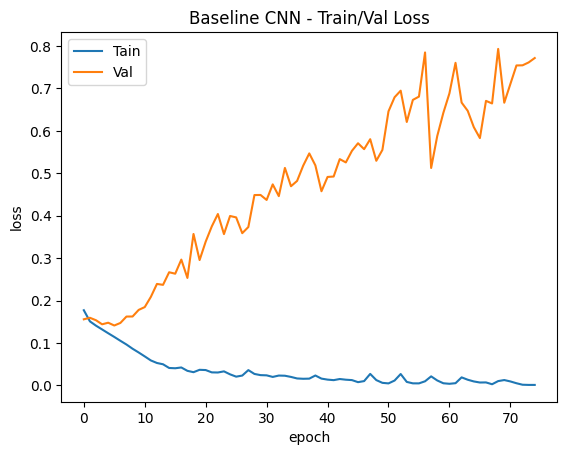

In [ ]:
#plot loss
plot_loss(history_cnn_baseline, 'Baseline CNN - Train/Val Loss')

### Experiment 1: Deeper Model with Regularization

In [130]:
# setup checkpoint
checkpoint_filepath = '/content/drive/MyDrive/Datasets/sepsis/models/cnn-e1.keras'
model_checkpoint_callback_c1 = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

cnn_e1 = tf.keras.Sequential([

  tf.keras.layers.Input(shape=X_train.shape[1:]),
  tf.keras.layers.Normalization(axis=None),

  tf.keras.layers.Conv1D(512, kernel_size=3, activation='relu', padding='causal'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.MaxPooling1D(2),

  tf.keras.layers.Conv1D(512, kernel_size=3, activation='relu', padding='causal'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.MaxPooling1D(2),

  tf.keras.layers.Conv1D(256, kernel_size=3, activation='relu', padding='causal', kernel_regularizer = tf.keras.regularizers.l1(0.01)),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.MaxPooling1D(2),

  tf.keras.layers.Conv1D(256, kernel_size=3, activation='relu', padding='causal', kernel_regularizer = tf.keras.regularizers.l1(0.01)),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.MaxPooling1D(2),

  tf.keras.layers.Flatten(),

  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [131]:
cnn_e1.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization_25 (Normalization)     │ (None, 24, 32)              │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_61 (Conv1D)                   │ (None, 24, 512)             │          49,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_144 (Dropout)                │ (None, 24, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_61 (MaxPooling1D)      │ (None, 12, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_62 (Conv1D)                   │ (None, 12, 512)             │         786,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_145 (Dropout)                │ (None, 12, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_62 (MaxPooling1D)      │ (None, 6, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_63 (Conv1D)                   │ (None, 6, 256)              │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_146 (Dropout)                │ (None, 6, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_63 (MaxPooling1D)      │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_64 (Conv1D)                   │ (None, 3, 256)              │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_147 (Dropout)                │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_64 (MaxPooling1D)      │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_79 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_148 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_80 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_149 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_81 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,558,788 (5.95 MB)

 Trainable params: 1,558,785 (5.95 MB)

 Non-trainable params: 3 (16.00 B)

Epoch 1/30
611/611 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - binary_accuracy: 0.8336 - f1_score: 0.1259 - loss: 24.1510 - precision_15: 0.2504 - recall_15: 0.6630 - val_binary_accuracy: 0.9459 - val_f1_score: 0.1273 - val_loss: 1.0990 - val_precision_15: 0.5924 - val_recall_15: 0.6566
Epoch 2/30
611/611 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - binary_accuracy: 0.8963 - f1_score: 0.1247 - loss: 1.1510 - precision_15: 0.3579 - recall_15: 0.6865 - val_binary_accuracy: 0.9611 - val_f1_score: 0.1273 - val_loss: 1.0895 - val_precision_15: 0.7483 - val_recall_15: 0.6446
Epoch 3/30
611/611 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - binary_accuracy: 0.9069 - f1_score: 0.1233 - loss: 1.1486 - precision_15: 0.3836 - recall_15: 0.6773 - val_binary_accuracy: 0.9619 - val_f1_score: 0.1273 - val_loss: 1.0147 - val_precision_15: 0.7626 - val_recall_15: 0.6386
Epoch 4/30
611/611 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.8949 - f1_score: 0.1188 - loss: 1.1278 - precision_15: 0.3345 - recall_15: 0.6623 - val_bi

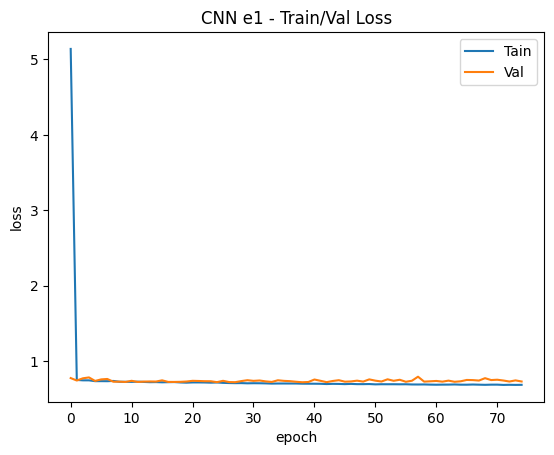

In [132]:
# Train the model
history_cnn_e1 = compile_and_train_adam(cnn_e1, model_checkpoint_callback_c1)

#plot loss
plot_loss(history_cnn_e1, 'CNN e1 - Train/Val Loss')

In [133]:
# load best checkpoint
cnn_e1_best = tf.keras.models.load_model('/content/drive/MyDrive/Datasets/sepsis/models/cnn-e1.keras')

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


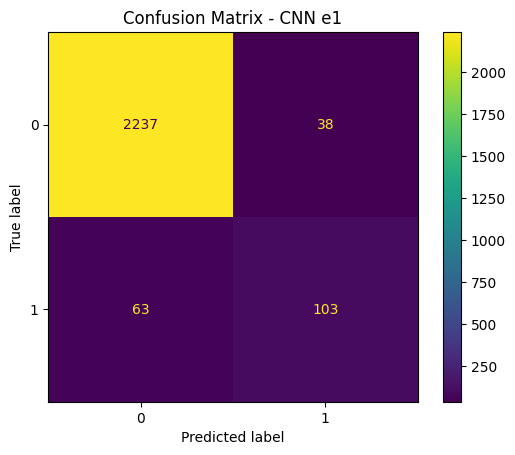

In [134]:
predict_and_plot_confusion(cnn_e1_best, "Confusion Matrix - CNN e1")